# 전이 학습

이미지 분류를 위한 CNN(Convolutional Neural Network)은 가장자리, 모서리 등과 같은 특징을 추출하는 여러 계층으로 구성됩니다. 그런 다음 최종 완전 연결 레이어를 사용하여 개체를 분류합니다. 다음과 같이 시각화 할 수 있습니다.

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*전이 학습*은 기존의 학습 된 모델을 가져 와서 특성 추출 계층을 재사용하여 최종 분류 계층을 사용자 지정 이미지로 훈련 된 완전 연결 계층으로 대체 할 수있는 기술 입니다. 이 기술을 사용하면 모델은 기본 모델 (액세스 권한이있는 것보다 더 큰 학습 데이터 세트를 기반으로 할 수 있음)에서 수행 된 특성 추출 학습을 통해 고유한 특정 객체 클래스 집합에 대한 분류 모델을 구축 할 수 있습니다.

이게 무슨 도움이 될까요? 예를 들어보면 여러분이 프로 테니스 선수와 완전히 초보자를 데리고, 그들에게 라켓볼을 어떻게 하는지 가르치려고 노력한다고 가정해봅시다. 라켓볼에 관련된 기본 기술 중 많은 것들이 이미 학습되어 있기 때문에 프로 테니스 선수가 훈련하기 더 쉬울 것이라고 추측하는 것이 타당 합니다. 마찬가지로, 사전 교육된 CNN 모델은 가장자리 및 모서리와 같은 공통 객체의 특징을 식별하는 방법을 이미 배웠기 때문에 특정 객체 세트를 분류하기 위해 훈련하기가 더 쉬울 수 있습니다. 기본적으로, 사전 교육된 모델은 교육할 데이터가 제한된 경우에도 효과적인 분류기를 생성할 수 있는 좋은 방법이 될 수 있습니다.

이 노트에서는 TensorFlow를 사용하여 분류 모델에 대한 이전 학습을 구현하는 방법을 알아보겠습니다.

## TensorFlow 라이브러리 설치 및 가져 오기

**TensorFlow** 패키지의 최신 버전이 설치되어 있는지 확인하고 사용할 Tensorflow 라이브러리를 가져오는 것으로 시작하겠습니다.

In [1]:
# !pip install --upgrade tensorflow

In [2]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.5.0
Keras version: 2.5.0


## 기본 모델 준비

전이 학습을 사용하려면 훈련 된 특징 추출(feature extraction) 계층을 사용할 수 있는 기본 모델이 필요합니다. ***resnet*** 모델은 224x224 픽셀의 3(RGB)색 채널 이미지로 구성된 방대한 데이터 세트를 사용하여 사전 학습 CNN 기반 이미지 분류기 입니다. 최종 예측 레이어를 제외하고 사전 훈련된 가중치로 인스턴스를 생성해보겠습니다.

In [3]:
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print(base_model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

## 이미지 데이터 준비

사전 교육된 모델에는 이미지 데이터에서 피쳐 추출하는 convolution 부터 여러가지 레이어가 있습니다.

사용자 이미지와 함께 피쳐 추출을 하려면 예측 레이어을 학습하는데 사용하는 이미지 데이터의 피쳐 수(픽셀 값)가 원래 피쳐 추출 레이어를 학습하는 데 사용된 이미지와 같으므로 224x224픽셀 크기의 컬러 이미지에 대한 데이터가 필요합니다.

Tensorflow에도 데이터를 로드하고 변환하는 함수가 포함되어 있습니다. 이를 사용하여 훈련 데이터용 생성기를 만들고 테스트 데이터용 두 번째 생성기를 만듭니다 (학습 된 모델의 유효성을 검사하는 데 사용할). loader는 원본 resnet CNN 모델을 훈련하고 정규화하는 데 사용 된 형식과 일치하도록 이미지 데이터를 변환합니다.

다음 셀을 실행하여 ImageDataGenerator(데이터 생성기)를 정의하고 이미지의 클래스를 나열합니다.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = 'data/shapes'
pretrained_size = (224,224)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.
class names:  ['circle', 'square', 'triangle']


## 예측 레이어 만들기

최종 예측 레이어를 제외한 *resnet* 모델 전체를 다운로드 했으므로 이러한 레이어를 피쳐 추출 레이어에서 평탄한 출력을 가져와 각 이미지 클래스에 대한 예측을 생성하는 완전히 연결된(*dense*) 계층과 결합해야 합니다.

또한 훈련 된 가중치를 유지하기 위해 피쳐 추출 레이어를 고정해야합니다. 그런 다음 이미지를 사용하여 모델을 학습 할 때 최종 예측 레이어만 새로운 가중치와 편향 값을 학습합니다. 특성 추출을 위해 이미 학습 된 사전 학습 된 가중치는 동일하게 유지됩니다.

In [5]:
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create prediction layer for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## 모델 훈련

CNN 레이어가 정의 되었으므로 이미지 데이터를 사용하여 훈련할 준비가 되었습니다. 기본 resnet 모델의 피쳐 추출 레이어에 사용 된 가중치는 훈련에 의해 변경되지 않으며 특성을 모양 클래스에 매칭하는 최종 dense 레이어 만 훈련됩니다.

In [6]:
# Train the model over 3 epochs
num_epochs = 3
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/3
28/28 [==============================] - 22s 724ms/step - loss: 2.6551 - accuracy: 0.5024 - val_loss: 1.0050 - val_accuracy: 0.6167
Epoch 2/3
28/28 [==============================] - 19s 698ms/step - loss: 0.3535 - accuracy: 0.8512 - val_loss: 0.1448 - val_accuracy: 0.9639
Epoch 3/3
28/28 [==============================] - 19s 690ms/step - loss: 0.1402 - accuracy: 0.9833 - val_loss: 0.1275 - val_accuracy: 0.9861


## Loss(손실) 확인하기

각 epoch에 대한 평균 훈련 및 검증 손실을 추적합니다. 그 이유는 모델이 학습됨에 따라 손실이 감소했는지 확인하고 *과적합* (검증 데이터의 손실이 평준화 되거나 증가하기 시작한 후에도 학습 데이터의 손실이 계속적으로 감소함을 나타냄)을 감지하기 위해 이를 시각화 하여 살펴봅니다.

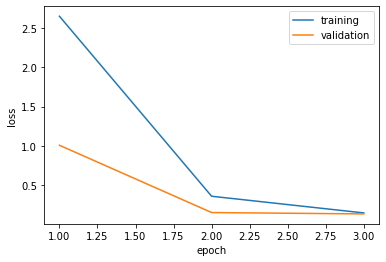

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 모델 성능 평가

테스트 데이터를 기반으로 최종 정확도를 볼 수 있지만 일반적으로 성능 메트릭을 좀 더 자세히 살펴 보는게 좋습니다. 모델이 각 클래스를 얼마나 잘 예측하는지 확인하기 위해 confusion matrix(혼동 행렬)을 시각화 해 보겠습니다.

Generating predictions from validation data...


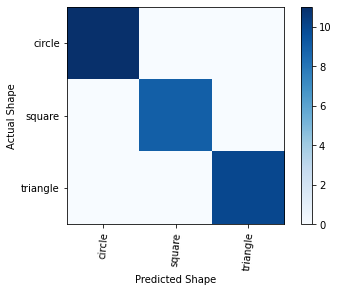

In [8]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## 훈련된 모델 사용

이제 모델을 학습 했으므로 이미지 클래스를 예측하는 데 사용할 수 있습니다. 

circle


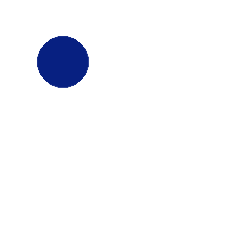

In [9]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((224,224), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
class_idx = predict_image(model, img)
print (classnames[class_idx])

## Learn More

* [Tensorflow Documentation](https://www.tensorflow.org/tutorials/images/transfer_learning)